In [1]:
using QuantumOptics

In [193]:
function initializeHamiltonian(Vdd, gamma, delta, omega, decay, decayDrive)
    b = NLevelBasis(3)
    
    tgr = transition(b, 1, 2)
    trR = transition(b, 2, 3)
    eg = transition(b, 1, 1)
    er = transition(b, 2, 2)
    eR = transition(b, 3, 3)
    

    H = omega/2*(tgr + dagger(tgr)) + (Vdd*trR + conj(Vdd)*dagger(trR))/2 + gamma*eg + delta*eR
    
    J = [sqrt(decay)*(er - eR); sqrt(decayDrive)*(eg - er)]

    return b, H, J
end
b, Ham, Jp = initializeHamiltonian(1e6, 0, 0, 1e6, 0.0e6, 0.5e6);


# Dynamics Calculation

0.33398904061678836 + 0.0im

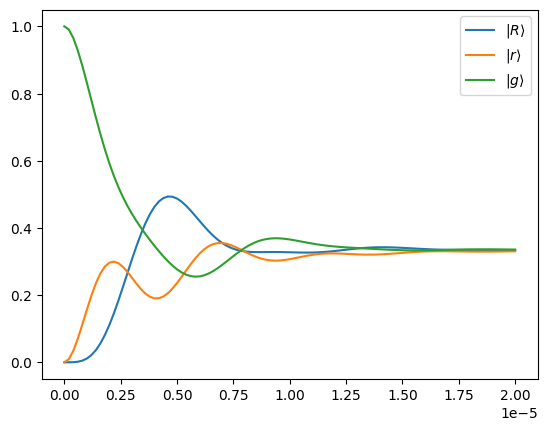

PyObject <matplotlib.legend.Legend object at 0x30747af40>

In [194]:
psi0 = basisstate(b, 1)
tend = 20e-6
T = [0:tend/100:tend;]
tout, psit = timeevolution.master(T, psi0, Ham, Jp; seed=2)
print(expect(dm(basisstate(b, 3)), psit)[end])
using PyPlot
plot(tout, expect(dm(basisstate(b, 3)), psit), label=L"$|R\rangle$")
plot(tout, expect(dm(basisstate(b, 2)), psit), label=L"$|r\rangle$")
plot(tout, expect(dm(basisstate(b, 1)), psit), label=L"$|g\rangle$")
legend()

In [195]:

function simulateDetuningScan(deltaArray;Vdd = 1,gamma = 0,   omega = 1, decay = 0.5, decayDrive = 0.0 )
    eqR = zeros(size(deltaArray))

    for (ind, delta) in enumerate(deltaArray)
        b, Ham, Jp = initializeHamiltonian(Vdd, gamma, delta, omega, decay, decayDrive);
        psi0 = basisstate(b, 1)

        T = [0:0.01:40;]
        tout, psit = timeevolution.master(T, psi0, Ham, Jp; seed=2)
        eqR[ind] = abs(expect(dm(basisstate(b, 3)), psit)[end])
    end
    return eqR
end

simulateDetuningScan (generic function with 1 method)

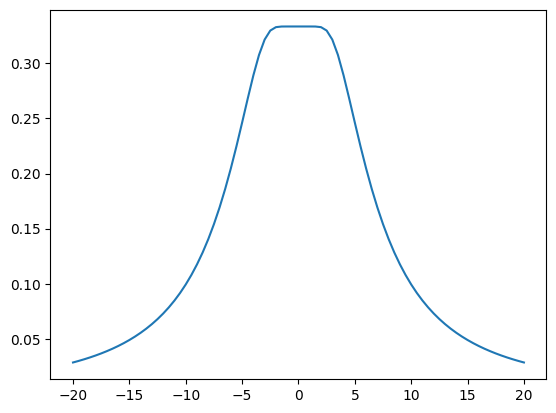

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x30754a160>

In [196]:
deltaArray = [-20:0.5:20...]
rydPop = simulateDetuningScan(deltaArray, Vdd = 1,  decay= 0.6)
plot(deltaArray, rydPop)


# Add Distance Randomization

In [197]:
using Random
using Statistics
using NearestNeighbors
using Distributions

#Conversion Factors and Constants
amuToKg=  1.66054e-27 
e = 1.602176634e-19;
a0 = 5.29177210903e-11;
Debye = 0.39*e*a0;
epsilon0 = 8.8541878128e-12;
hbar = 1.05457182e-34;
kB = 1.38064852e-23;



Rb = Dict("mass" => 85.467*amuToKg, 'w'=> 2*pi* [84, 183, 183 ], "Dipole"=>  8000*a0*e)
KRb = Dict("mass"=>  (39.0983 + 85.467)*amuToKg, "w"=> 2*pi* [110,240,240 ], "Dipole"=> 0.56*Debye )
function generateAtoms(mu, AtomNum, TrapFreq, KbT)
    coordList = []
    for TrapFreqI in TrapFreq
        sigma = sqrt(KbT / TrapFreqI)
        coord = rand(Normal(mu, sigma), AtomNum)
        push!(coordList, coord)
    end
    return hcat(coordList...)
end


function exciteRydberg(AtomCoord, numOfRyd)
    AtomInd = collect(1:size(AtomCoord, 1))
    
    indofRyd = sort(sample(AtomInd, numOfRyd, replace=false))
    
    RydCoord = vcat([AtomCoord[indRyd, :] for indRyd in indofRyd]'...)
    
    
    #NonRyd = deleteat!(AtomCoord, indofRyd)#[deleteat!(copy(AtomCoord[:, i]), indofRyd) for i in 1:size(AtomCoord, 2)]
    NonRyd = vcat(deleteat!([eachrow(AtomCoord)...], indofRyd)'...)
    return RydCoord, NonRyd
end


function findNearestNeighbor(RydCoord, KRbCoord; )
    tree = KDTree(KRbCoord')
    closestNeighborList = []
    
    for atom in eachrow(RydCoord)
        
        indOfKRb, dist2Krb = knn(tree, atom, 1)
        
        push!(closestNeighborList, (dist2Krb, indOfKRb))
    end
    return closestNeighborList
end


function initializeHamiltonian(Vdd, gamma, delta, omega, decay, decayDrive)
    b = NLevelBasis(3)
    
    tgr = transition(b, 1, 2)
    trR = transition(b, 2, 3)
    eg = transition(b, 1, 1)
    er = transition(b, 2, 2)
    eR = transition(b, 3, 3)
    

    H = omega/2*(tgr + dagger(tgr)) + (Vdd*trR + conj(Vdd)*dagger(trR))/2 + gamma*eg + delta*eR
    
    J = [sqrt(decay)*(er - eR); sqrt(decayDrive)*(eg - er)]

    return b, H, J
end

function getInteractionStrength(NeighList; gamma = 0, delta = 0, omega = 0, decay = 0, decayDrive = 0.0, mul = 1)
    HamiltonianArray = []
    for atomInfo in NeighList
        distance = atomInfo[1][1]
        rabi = Rb["Dipole"]*KRb["Dipole"]/(4*pi*epsilon0*distance^3)/(hbar)
        b, H, J = initializeHamiltonian(rabi/2*mul, gamma, delta, omega, decay, decayDrive)
        push!(HamiltonianArray, [b, H, J])
    end
    
    return HamiltonianArray
end

function timeEvolve(DynamicsArray, tend)
    b, Ham, Jp = DynamicsArray
    psi0 = basisstate(b, 1)
    
    T = [0:tend/100:tend;]
    tout, psit = timeevolution.master(T, psi0, Ham, Jp; seed=2)
    return tout, psit
end

function plotTimeDynamics(b, tout, psit)
    psit = [expect(dm(basisstate(b, 1)), psit),expect(dm(basisstate(b, 2)), psit), expect(dm(basisstate(b, 3)), psit)] 
    plotTimeDynamics(tout, psit)
end

function plotTimeDynamics(tout, psit::Vector{Vector{ComplexF64}})
    fig = figure()
    ax = fig[:add_subplot](1, 1, 1)  # Create a subplot

     ax[:plot](tout, psit[3], label=L"$|R\rangle$")
     ax[:plot](tout, psit[2], label=L"$|r\rangle$")
     ax[:plot](tout, psit[1], label=L"$|g\rangle$")
    ax[:set_xlabel]("Time (s)")
    ax[:set_ylabel]("Population Fraction")
    ax[:set_title]("Time dynamics")
        ax[:legend]()
    return ax
end
function averagedDynamics(b, psit_array)
    psit = [mean([expect(dm(basisstate(b, i)), psit) for psit in psit_array], dims = 1)[1] for i in 1:3]
    
    return psit
end

    

averagedDynamics (generic function with 1 method)

# Distance Sampling

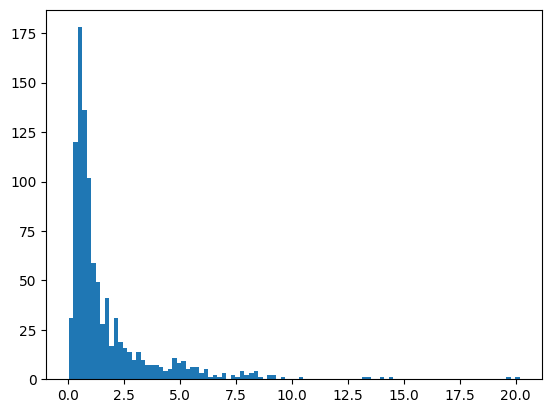

In [198]:
numOfCycles = 1000
distanceHist = []
for cycle in 1:numOfCycles
    NumOfRb = 8000
    NumOfKRb = 8000
    Temp =  0.5e-6 
    RbAtomCoord = generateAtoms(0, NumOfRb, Rb["mass"]*Rb['w'].^2, kB*Temp) #Rb coord
    KRbAtomCoord = generateAtoms(0, NumOfKRb, KRb["mass"]*KRb["w"].^2, kB*Temp) #Krb Coord
    RydCoord, NonRyd = exciteRydberg(RbAtomCoord,1) #Returns the coordinates of the Rydberg atoms
    NeighborInfo = findNearestNeighbor(RydCoord, KRbAtomCoord)
    push!(distanceHist, NeighborInfo[1][1][1]*1e6)
end

hist(distanceHist, bins = 100);


In [85]:
length(distanceHist[distanceHist .< 3])

856

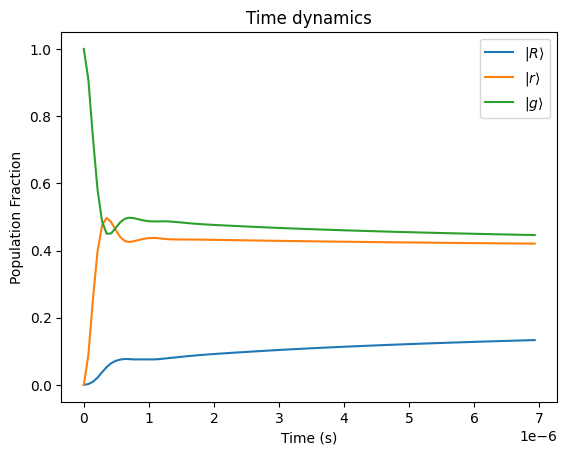

PyObject <Axes: title={'center': 'Time dynamics'}, xlabel='Time (s)', ylabel='Population Fraction'>

In [276]:
numOfCycles = 100

tend = 7e-6
psi_array = []
for cycle in 1:numOfCycles
    NumOfRb = 800
    NumOfKRb = 800
    Temp =  0.5e-6 
    RbAtomCoord = generateAtoms(0, NumOfRb, Rb["mass"]*Rb['w'].^2, kB*Temp) #Rb coord
    KRbAtomCoord = generateAtoms(0, NumOfKRb, KRb["mass"]*KRb["w"].^2, kB*Temp) #Krb Coord
    RydCoord, NonRyd = exciteRydberg(RbAtomCoord,1) #Returns the coordinates of the Rydberg atoms
    NeighborInfo = findNearestNeighbor(RydCoord, KRbAtomCoord)
    Dynamicsarray = getInteractionStrength(NeighborInfo, gamma = 0e6, delta = 0e6, omega = 10e6, decay = 0e6, decayDrive = 5e6, mul = 1)
    tout, psit = timeEvolve(Dynamicsarray[1], tend)
    push!(psi_array, psit)
end
psi_ta = averagedDynamics(b, psi_array)
plotTimeDynamics(tout, psi_ta)


In [ ]:
function initializeExperiment(;NumOfRb = 8000, NumOfKRb = 8000, Temp = 0.5e-6)

    RbAtomCoord = generateAtoms(0, NumOfRb, Rb["mass"]*Rb['w'].^2, kB*Temp) #Rb coord
    KRbAtomCoord = generateAtoms(0, NumOfKRb, KRb["mass"]*KRb["w"].^2, kB*Temp) #Krb Coord
    return RbAtomCoord, KRbAtomCoord
end

function simulateDetuningScanMC(deltaArray; gamma = 0,  omega = 1e6, decay = 0.0, decayDrive = 0.0, mul = 1)
    eqR = zeros(size(deltaArray))
    numOfCycles = 500
    for (indOI, delta) in enumerate(deltaArray)
        tend = 7e-6
        psi_array = []
        for cycle in 1:numOfCycles
            RbAtomCoord, KRbAtomCoord = initializeExperiment()
            RydCoord, NonRyd = exciteRydberg(RbAtomCoord,1) #Returns the coordinates of the Rydberg atoms
            NeighborInfo = findNearestNeighbor(RydCoord, KRbAtomCoord)
            Dynamicsarray = getInteractionStrength(NeighborInfo, gamma = gamma, delta = delta, omega = omega, decay = decay, decayDrive = decayDrive, mul = mul)
            tout, psit = timeEvolve(Dynamicsarray[1], tend)
            push!(psi_array, psit)
        end
        psi_ta = averagedDynamics(b, psi_array)
        #plotTimeDynamics(tout, psi_ta)

        #break
        eqR[indOI] = real(psi_ta[3][end])
    end
    
    return eqR
end

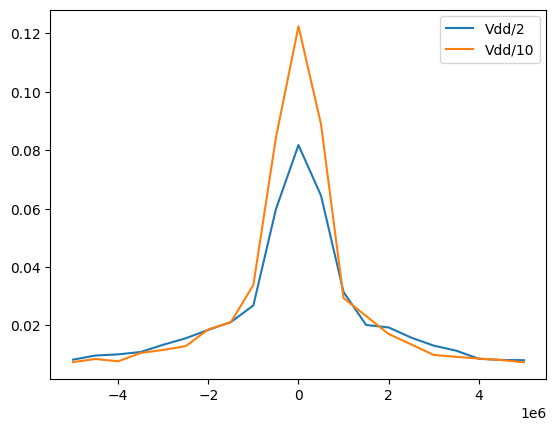

PyObject <matplotlib.legend.Legend object at 0x30fb61e80>

In [239]:
deltaArray = [-5:0.5:5...]*1e6
rydPop = simulateDetuningScanMC(deltaArray, omega = 1e6 , decayDrive = 0e6, mul = 0.5)
plot(deltaArray, rydPop, label = "Vdd/2")
rydPop = simulateDetuningScanMC(deltaArray, omega = 1e6 , decayDrive = 0e6, mul = 0.1)
plot(deltaArray, rydPop, label = "Vdd/10")
legend()